In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
from tqdm import tqdm

In [14]:
"""
hyperparameters:
- batch size = 32
- learning rate = 0.001
"""
batch_size = 128
learning_rate = 0.0002
device = torch.device('cuda' if torch.cuda.is_available() else 'mps')
g_input_size = 64
d_input_size = 28*28
hidden_size = 256   

In [17]:
from torchvision.transforms import Normalize, ToTensor
from torch import optim

"""
Only download the training data and Convert it to Pytorch Tensor
"""
transform = transforms.Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
criterion = nn.BCELoss()

num_epochs = 200

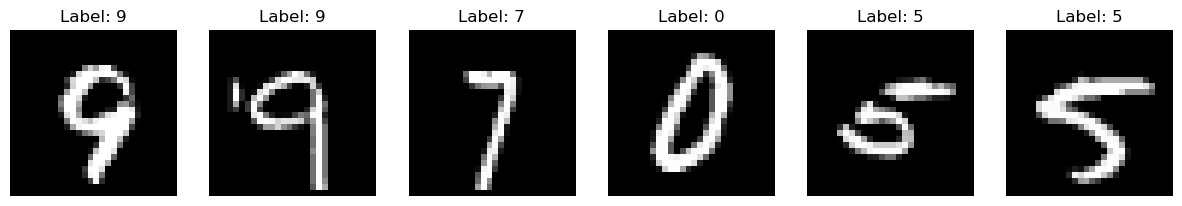

In [18]:
"""
Visualize parts of training data
"""
# obtain data from training loader
data_iter = iter(train_loader)
images, labels = next(data_iter)

fig, axes = plt.subplots(1, 6, figsize=(15, 3))
for i in range(6):
    ax = axes[i]
    ax.imshow(images[i].numpy().squeeze(), cmap='gray')
    ax.set_title(f'Label: {labels[i].item()}')
    ax.axis('off')
plt.show()

In [19]:
"""
Definition of Generator and Discriminator
"""
discriminator = nn.Sequential(
    nn.Linear(d_input_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())

generator = nn.Sequential(
    nn.Linear(g_input_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, d_input_size),
    nn.Tanh())
discriminator = discriminator.to(device)
generator = generator.to(device)

In [20]:
"""
training together
"""
d_optimizer = optim.Adam(discriminator.parameters(), lr=learning_rate)
g_optimizer = optim.Adam(generator.parameters(), lr=learning_rate)

# 记录每个 epoch 的损失和指标
d_losses = []
g_losses = []
d_real_values = []
d_fake_values = []
g_output_values = []

# GAN 训练循环
for epoch in range(num_epochs):
    d_loss_epoch = 0
    g_loss_epoch = 0
    d_real_sum = 0
    d_fake_sum = 0
    g_output_sum = 0
    num_batches = 0

    for real_images, _ in train_loader:
        real_images = real_images.view(-1, 784).to(device)  # 展平图像到 (batch_size, 784)
        batch_size = real_images.size(0)
        num_batches += 1

        # 真实和假样本的标签
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # 训练判别器
        z = torch.randn(batch_size, g_input_size).to(device)
        fake_images = generator(z)

        d_optimizer.zero_grad()
        real_output = discriminator(real_images)  # D(x)
        fake_output = discriminator(fake_images.detach())  # D(G(z))
        d_loss_real = criterion(real_output, real_labels)
        d_loss_fake = criterion(fake_output, fake_labels)
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        d_optimizer.step()
        d_loss_epoch += d_loss.item()

        # 累加 D(x) 和 D(G(z)) 的值
        d_real_sum += real_output.mean().item()
        d_fake_sum += fake_output.mean().item()

        # 训练生成器
        g_optimizer.zero_grad()
        fake_output = discriminator(fake_images)  # 再次计算 D(G(z)) 用于生成器损失
        g_loss = criterion(fake_output, real_labels)
        g_loss.backward()
        g_optimizer.step()
        g_loss_epoch += g_loss.item()

        # 累加 G(z) 的值
        g_output_sum += fake_images.mean().item()

    # 记录每个 epoch 的平均值
    avg_d_loss = d_loss_epoch / num_batches
    avg_g_loss = g_loss_epoch / num_batches
    avg_d_real = d_real_sum / num_batches
    avg_d_fake = d_fake_sum / num_batches
    avg_g_output = g_output_sum / num_batches

    d_losses.append(avg_d_loss)
    g_losses.append(avg_g_loss)
    d_real_values.append(avg_d_real)
    d_fake_values.append(avg_d_fake)
    g_output_values.append(avg_g_output)

    # 每 50 个 epoch 保存一次模型参数
    if (epoch + 1) % 50 == 0:
        torch.save(generator.state_dict(), f'generator_epoch_{epoch+1}.pth')
        torch.save(discriminator.state_dict(), f'discriminator_epoch_{epoch+1}.pth')

    # 打印每个 epoch 的 D(x), D(G(z)), G(z) 总结
    print(f"Epoch [{epoch+1}/{num_epochs}] Summary:")
    print(f"D Loss: {avg_d_loss:.4f}, G Loss: {avg_g_loss:.4f}")
    print(f"D(x): {avg_d_real:.4f}, D(G(z)): {avg_d_fake:.4f}, G(z): {avg_g_output:.4f}")

Epoch [1/200] Summary:
D Loss: 0.2508, G Loss: 3.7537
D(x): 0.9510, D(G(z)): 0.1525, G(z): -0.2439
Epoch [2/200] Summary:
D Loss: 0.0879, G Loss: 5.0025
D(x): 0.9726, D(G(z)): 0.0444, G(z): -0.4170
Epoch [3/200] Summary:
D Loss: 0.3519, G Loss: 4.6647
D(x): 0.9132, D(G(z)): 0.1162, G(z): -0.5233
Epoch [4/200] Summary:
D Loss: 0.3355, G Loss: 3.9059
D(x): 0.8955, D(G(z)): 0.1221, G(z): -0.6164
Epoch [5/200] Summary:
D Loss: 0.4565, G Loss: 3.7325
D(x): 0.8702, D(G(z)): 0.1493, G(z): -0.6346
Epoch [6/200] Summary:
D Loss: 0.6364, G Loss: 2.8959
D(x): 0.8182, D(G(z)): 0.1997, G(z): -0.6712
Epoch [7/200] Summary:
D Loss: 0.6512, G Loss: 2.9469
D(x): 0.8119, D(G(z)): 0.2030, G(z): -0.6770
Epoch [8/200] Summary:
D Loss: 0.8024, G Loss: 2.9368
D(x): 0.7872, D(G(z)): 0.2307, G(z): -0.6730
Epoch [9/200] Summary:
D Loss: 0.5342, G Loss: 2.6370
D(x): 0.8291, D(G(z)): 0.1822, G(z): -0.7106
Epoch [10/200] Summary:
D Loss: 0.2955, G Loss: 3.1495
D(x): 0.9024, D(G(z)): 0.1029, G(z): -0.7199
Epoch [11

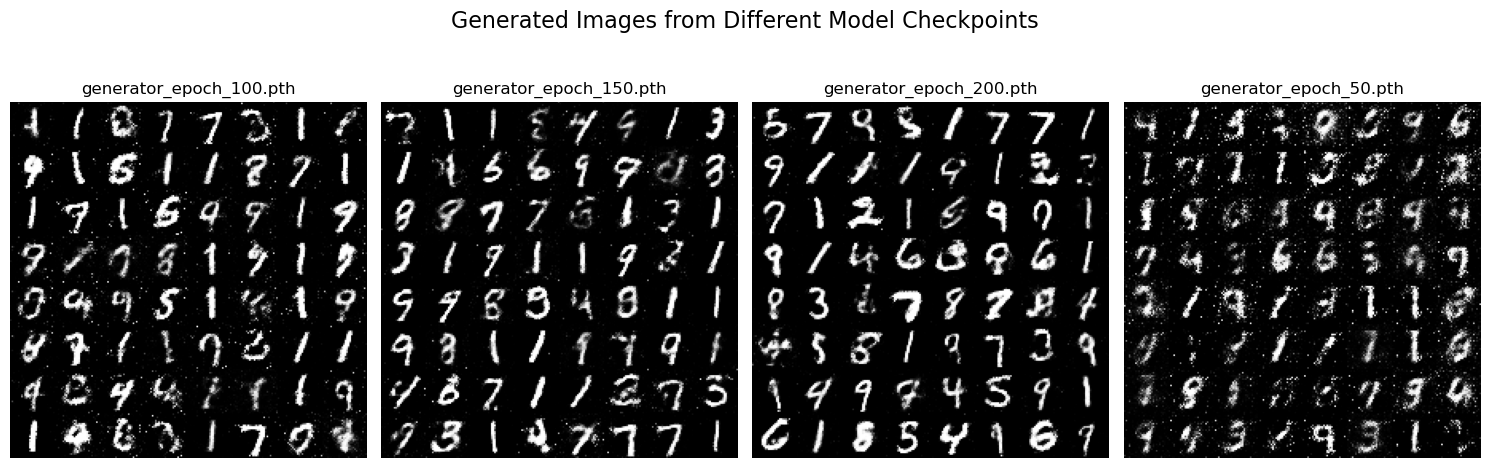

In [21]:
import glob

# 函数用于加载模型参数并生成图片
def generate_images_from_checkpoint(checkpoint_path, num_images=64):
    # 加载生成器的参数
    generator.load_state_dict(torch.load(checkpoint_path,weights_only=False))
    generator.eval()  # 设置为评估模式

    # 生成随机噪声输入
    z = torch.randn(num_images, g_input_size).to(device)
    with torch.no_grad():  # 不需要计算梯度
        generated_images = generator(z)

    # 将生成的图片调整回 [0, 1] 的范围并转为 NumPy 数组
    generated_images = (generated_images + 1) / 2  # 假设使用 Tanh，恢复到 [0, 1] 范围
    generated_images = generated_images.cpu().numpy()

    return generated_images

# 获取所有模型参数文件路径
model_paths = sorted(glob.glob('generator_epoch_*.pth'))
# 设置每个模型生成的图片数和网格大小
num_images_per_model = 64  # 每个模型生成 64 张图片
grid_size = int(num_images_per_model ** 0.5)  # 假设是 8x8 网格
# 创建横向子图排列
fig, axes = plt.subplots(1, len(model_paths), figsize=(15, 5))
fig.suptitle('Generated Images from Different Model Checkpoints', fontsize=16)

# 遍历每个模型文件并生成图片
for i, model_path in enumerate(model_paths):
    generated_images = generate_images_from_checkpoint(model_path, num_images=num_images_per_model)

    # 将生成的图片批次转换为网格格式
    image_grid = generated_images.reshape(grid_size, grid_size, 28, 28).transpose(0, 2, 1, 3).reshape(grid_size * 28, grid_size * 28)

    # 在子图中显示生成的图片网格
    ax = axes[i]
    ax.imshow(image_grid, cmap='gray')  # 假设是灰度图像
    ax.set_title(f'{model_path}')
    ax.axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.85)  # 调整顶部间距以显示标题
plt.show()

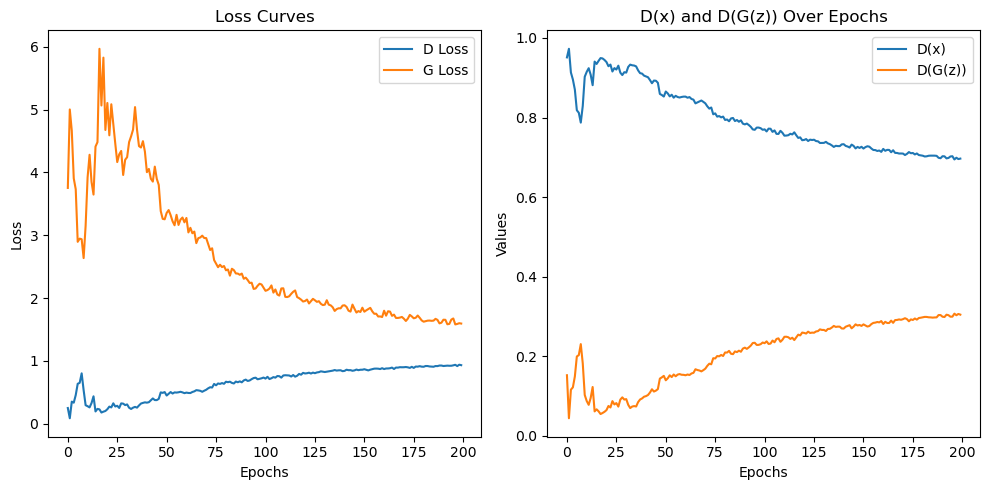

In [22]:
# 创建两个子图横向排列
plt.figure(figsize=(10, 5))

# 绘制损失曲线图
plt.subplot(1, 2, 1)
plt.plot(d_losses, label='D Loss')
plt.plot(g_losses, label='G Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()

# 绘制 D(x) 和 D(G(z)) 曲线图
plt.subplot(1, 2, 2)
plt.plot(d_real_values, label='D(x)')
plt.plot(d_fake_values, label='D(G(z))')
plt.xlabel('Epochs')
plt.ylabel('Values')
plt.title('D(x) and D(G(z)) Over Epochs')
plt.legend()

plt.tight_layout()  # 自动调整子图间的间距
plt.show()